In [32]:
%load_ext autoreload
%autoreload 1
%aimport redditClient

In [321]:
from redditClient import redditClient
import matplotlib.pyplot as plt
import praw
from collections import Counter

In [323]:
client = redditClient()

In [301]:
# for nvidia scrapping 
subreddits_nvidia = client.subreddit("nvidia+gpu+graphicscard")
# for amd scrapping 
subreddits_amd = client.subreddit("amd+gpu+graphicscard")
# for intel scrapping 
subreddits_intel = client.subreddit("intel+gpu+graphicscard+intelarc")

## Defining GPUs 


In [309]:
gpu_all = {
    "nvidia": {
        "50": {
            "low": ["rtx 5060", "5060", "rtx 5060 ti", "5060 ti", "rtx5060", "rtx5060 ti"],
            "mid": ["rtx 5070", "5070", "5070 ti", "rtx 5070 ti", "rtx5070", "rtx5070ti", "rtx5070 ti"],
            "high": ["rtx 5080", "5080", "rtx5080"],
            "top": ["5090", "rtx 5090", "rtx5090"]
        },
        "40": {
            "low": [
                "4060", "4060ti",
                "rtx4060",
            ],
            "mid": [
                "rtx4070", "4070", 
                "4070ti"
            ],
            "high": ["4080", "rtx4080"],
            "top": ["4090", "4090", "rtx4090"]
        },
        "30": {
            "low": ["3060", "3060ti", "rtx3060"],
            "mid": [
                "3070", "3070ti","rtx3070"
            ],
            "high": [
                "3080", "3080ti", "rtx3080",
            ],
            "top": ["3090", "3090ti", "rtx3090"]
        }
    },
    "amd": {
        "9000": {
            "mid": ["rx 9070 xt", "9070 xt", "9070", "rx 9070", "rx9070", "rx9070 xt", "rx9070xt"]
        },
        "7000": {
            "low": [
                "7600", "7600xt", "rx7600"
            ],
            "mid": [
                "7700xt", "rx7700",
                "7700"
            ],
            "high": ["7800xt","7800", "7900gre", 
                     "7900 gre", "rx7800"],
            "top": ["7900xtx", 
                    "7900xt", "7900 xt", "7900 xtx", "rx7900"]
        },
        "6000": {
            "low": ["rx6400", "6400", "rx6500", "6500xt", "rx6600", 
                    "6600xt", "6600"],
            "mid": [
                "rx6700", "6700xt","6750",
                "6750xt", "6750", "rx6750", "6650", "rx6650", "6650xt",
                "rx6700"
            ],
            "high": ["6800xt", "rx6800", "6800"],
            "top": ["rx6950", "6950xt", "6950", "rx6900", "6900xt", "6900"]
        }
    },
    "intel": {
        "alchemist": {
            "380": ["arc 380", "a380"],
            "750": ["arc 750", "a750"],
            "770": ["arc 770", "a770"]
        },
        "battlemage": {
            "580": ["a580", "b580", "arc b580"],
            "570": ["arc b570", "b570", "a570"]
        }
    }
}


# Data Collection

## Collecting GPU data

In [ ]:
import json
import time
import re

def scrape_gpu_generation(brand, generation, target_posts=100, comment_limit=20, post_limit=1000): # defines how many posts and commments needed for each company
    tier_keywords = gpu_all[brand][generation]

    # assigns company to respective needed subreddits to scrape data
    if brand == "nvidia":
        subreddits = subreddits_nvidia
    elif brand == "amd":
        subreddits = subreddits_amd
    elif brand == "intel":
        subreddits = subreddits_intel
    else:
        subreddits = None  

    all_results = []
    for tier, keywords in tier_keywords.items():
        print(f"\n Scraping {brand.upper()} {generation} - {tier.upper()} tier...")
        query = " OR ".join(keywords) # defines or function in query for all keywords in gpu list
        tier_results = []
        returned, matched, skipped = 0, 0, 0

        for submission in subreddits.search(query=query, sort="relevance", time_filter="all", limit=post_limit):
            if len(tier_results) >= target_posts: # matches output data to target post limit
                break

            try:
                returned += 1
                submission.comments.replace_more(limit=0)
                post_text = (submission.title + " " + (submission.selftext or "")).lower()

                matched_keywords = [
                    kw for kw in keywords if re.search(rf'\b{re.escape(kw.lower())}\b', post_text)
                ]

                if not matched_keywords:
                    skipped += 1
                    continue

                matched += 1

                raw_comments = [
                    c for c in submission.comments.list()
                    if isinstance(c, praw.models.Comment)
                    and c.body.strip().lower() not in ["[deleted]", "[removed]"]
                ]

                top_comments = sorted(raw_comments, key=lambda x: x.score, reverse=True)[:comment_limit]
                comments = [c.body.strip() for c in top_comments]

                tier_results.append({
                    "brand": brand,
                    "generation": generation,
                    "tier": tier,
                    "matched_keywords": matched_keywords,
                    "title": submission.title,
                    "selftext": submission.selftext,
                    "comments": comments
                })

            except Exception as e:
                print(f" Error: {e}")
                time.sleep(5)
                
        # statements to depict if function can retrieve desired amount of posts
        print(f" {tier.upper()} tier summary:")
        print(f"  • Posts fetched: {returned}")
        print(f"  • Posts matched: {matched}")
        print(f"  • Posts skipped: {skipped}")
        print(f"  • Posts saved:   {len(tier_results)}")

        all_results.extend(tier_results)
        time.sleep(2)  # timer for api purposes

    filename = f"{brand}_{generation}_series1.json"
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(all_results, f, ensure_ascii=False, indent=2)

    print(f"\n Saved {len(all_results)} total posts across all tiers to {filename}")


In [145]:
scrape_gpu_generation("nvidia", "50")


 Scraping NVIDIA 50 - LOW tier...
 LOW tier summary:
  • Posts fetched: 103
  • Posts matched: 100
  • Posts skipped: 3
  • Posts saved:   100

 Scraping NVIDIA 50 - MID tier...
 MID tier summary:
  • Posts fetched: 114
  • Posts matched: 100
  • Posts skipped: 14
  • Posts saved:   100

 Scraping NVIDIA 50 - HIGH tier...
 HIGH tier summary:
  • Posts fetched: 247
  • Posts matched: 65
  • Posts skipped: 182
  • Posts saved:   65

 Scraping NVIDIA 50 - TOP tier...
 TOP tier summary:
  • Posts fetched: 234
  • Posts matched: 100
  • Posts skipped: 134
  • Posts saved:   100

 Saved 365 total posts across all tiers to nvidia_50_series.json


In [313]:
scrape_gpu_generation("nvidia", "50")


 Scraping NVIDIA 50 - LOW tier...
 LOW tier summary:
  • Posts fetched: 106
  • Posts matched: 100
  • Posts skipped: 6
  • Posts saved:   100

 Scraping NVIDIA 50 - MID tier...
 MID tier summary:
  • Posts fetched: 103
  • Posts matched: 100
  • Posts skipped: 3
  • Posts saved:   100

 Scraping NVIDIA 50 - HIGH tier...
 HIGH tier summary:
  • Posts fetched: 241
  • Posts matched: 73
  • Posts skipped: 168
  • Posts saved:   73

 Scraping NVIDIA 50 - TOP tier...
 TOP tier summary:
  • Posts fetched: 181
  • Posts matched: 100
  • Posts skipped: 81
  • Posts saved:   100

 Saved 373 total posts across all tiers to nvidia_50_series1.json


In [231]:
from collections import Counter

with open("nvidia_40_series1.json", "r", encoding="utf-8") as f:
    data = json.load(f)

tier_counts = Counter(post["tier"] for post in data)
print("Post distribution by tier:")
for tier, count in tier_counts.items():
    print(f"{tier.capitalize()}: {count} posts")


Post distribution by tier:
Low: 100 posts
Mid: 100 posts
High: 100 posts
Top: 71 posts


In [227]:
scrape_gpu_generation("nvidia", "40")


 Scraping NVIDIA 40 - LOW tier...
 LOW tier summary:
  • Posts fetched: 101
  • Posts matched: 100
  • Posts skipped: 1
  • Posts saved:   100

 Scraping NVIDIA 40 - MID tier...
 MID tier summary:
  • Posts fetched: 101
  • Posts matched: 100
  • Posts skipped: 1
  • Posts saved:   100

 Scraping NVIDIA 40 - HIGH tier...
 HIGH tier summary:
  • Posts fetched: 104
  • Posts matched: 100
  • Posts skipped: 4
  • Posts saved:   100

 Scraping NVIDIA 40 - TOP tier...
 TOP tier summary:
  • Posts fetched: 240
  • Posts matched: 71
  • Posts skipped: 169
  • Posts saved:   71

 Saved 371 total posts across all tiers to nvidia_40_series1.json


In [233]:
scrape_gpu_generation("nvidia", "30")


 Scraping NVIDIA 30 - LOW tier...
 LOW tier summary:
  • Posts fetched: 102
  • Posts matched: 100
  • Posts skipped: 2
  • Posts saved:   100

 Scraping NVIDIA 30 - MID tier...
 MID tier summary:
  • Posts fetched: 102
  • Posts matched: 100
  • Posts skipped: 2
  • Posts saved:   100

 Scraping NVIDIA 30 - HIGH tier...
 HIGH tier summary:
  • Posts fetched: 100
  • Posts matched: 100
  • Posts skipped: 0
  • Posts saved:   100

 Scraping NVIDIA 30 - TOP tier...
 TOP tier summary:
  • Posts fetched: 101
  • Posts matched: 100
  • Posts skipped: 1
  • Posts saved:   100

 Saved 400 total posts across all tiers to nvidia_30_series1.json


In [185]:
scrape_gpu_generation("amd", "9000")


 Scraping AMD 9000 - MID tier...
 MID tier summary:
  • Posts fetched: 102
  • Posts matched: 100
  • Posts skipped: 2
  • Posts saved:   100

 Saved 100 total posts across all tiers to amd_9000_series.json


In [219]:
scrape_gpu_generation("amd", "7000")


 Scraping AMD 7000 - LOW tier...
 LOW tier summary:
  • Posts fetched: 102
  • Posts matched: 100
  • Posts skipped: 2
  • Posts saved:   100

 Scraping AMD 7000 - MID tier...
 MID tier summary:
  • Posts fetched: 109
  • Posts matched: 100
  • Posts skipped: 9
  • Posts saved:   100

 Scraping AMD 7000 - HIGH tier...
 HIGH tier summary:
  • Posts fetched: 240
  • Posts matched: 81
  • Posts skipped: 159
  • Posts saved:   81

 Scraping AMD 7000 - TOP tier...
 TOP tier summary:
  • Posts fetched: 242
  • Posts matched: 71
  • Posts skipped: 171
  • Posts saved:   71

 Saved 352 total posts across all tiers to amd_7000_series.json


In [239]:
scrape_gpu_generation("amd", "6000")


 Scraping AMD 6000 - LOW tier...
 LOW tier summary:
  • Posts fetched: 108
  • Posts matched: 100
  • Posts skipped: 8
  • Posts saved:   100

 Scraping AMD 6000 - MID tier...
 MID tier summary:
  • Posts fetched: 108
  • Posts matched: 100
  • Posts skipped: 8
  • Posts saved:   100

 Scraping AMD 6000 - HIGH tier...
 HIGH tier summary:
  • Posts fetched: 102
  • Posts matched: 100
  • Posts skipped: 2
  • Posts saved:   100

 Scraping AMD 6000 - TOP tier...
 TOP tier summary:
  • Posts fetched: 101
  • Posts matched: 100
  • Posts skipped: 1
  • Posts saved:   100

 Saved 400 total posts across all tiers to amd_6000_series.json


In [245]:
scrape_gpu_generation("intel", "alchemist")


 Scraping INTEL alchemist - 380 tier...
 380 tier summary:
  • Posts fetched: 238
  • Posts matched: 71
  • Posts skipped: 167
  • Posts saved:   71

 Scraping INTEL alchemist - 750 tier...
 750 tier summary:
  • Posts fetched: 114
  • Posts matched: 100
  • Posts skipped: 14
  • Posts saved:   100

 Scraping INTEL alchemist - 770 tier...
 770 tier summary:
  • Posts fetched: 118
  • Posts matched: 100
  • Posts skipped: 18
  • Posts saved:   100

 Saved 271 total posts across all tiers to intel_alchemist_series.json


In [308]:
scrape_gpu_generation("intel", "battlemage")


 Scraping INTEL battlemage - 580 tier...
 580 tier summary:
  • Posts fetched: 103
  • Posts matched: 100
  • Posts skipped: 3
  • Posts saved:   100

 Scraping INTEL battlemage - 570 tier...
 570 tier summary:
  • Posts fetched: 246
  • Posts matched: 16
  • Posts skipped: 230
  • Posts saved:   16

 Saved 116 total posts across all tiers to intel_battlemage_series.json


## Collecting Data for Upscaling Technology

In [365]:
subreddits = client.subreddit("nvidia+amd+intel+pcgaming+pcmasterrace+buildapc+gpu+graphicscard+intelarc")

target_posts = 300
comment_limit = 30

# Set up the categories
categories = {
    "dlss_only": {
        "query": "DLSS -FSR -XeSS",
        "label": {"mentions_dlss": True, "mentions_fsr": False, "mentions_xess": False, "comparison": False}
    },
    "fsr_only": {
        "query": "FSR -DLSS -XeSS",
        "label": {"mentions_dlss": False, "mentions_fsr": True, "mentions_xess": False, "comparison": False}
    },
    "xess_only": {
        "query": "XeSS -DLSS -FSR",
        "label": {"mentions_dlss": False, "mentions_fsr": False, "mentions_xess": True, "comparison": False}
    },
    "comparison": {
        "query": "(DLSS AND FSR) OR (DLSS AND XeSS) OR (FSR AND XeSS)",
        "label": {"mentions_dlss": True, "mentions_fsr": True, "mentions_xess": True, "comparison": True}
    }
}

results = []

# Loop through each category
for tag, details in categories.items():
    print(f"\n Scraping: {tag.upper()}")
    matched = 0

    for submission in subreddits.search(query=details["query"], sort="relevance", time_filter="all", limit=1000):
        if matched >= target_posts:
            break
        try:
            submission.comments.replace_more(limit=0)
            post_text = (submission.title + " " + (submission.selftext or "")).lower()
            mentions_dlss = "dlss" in post_text
            mentions_fsr = "fsr" in post_text
            mentions_xess = "xess" in post_text
            comparison = sum([mentions_dlss, mentions_fsr, mentions_xess]) >= 2

            comments = [
                c.body.strip()
                for c in sorted(submission.comments.list(), key=lambda x: x.score, reverse=True)
                if isinstance(c, praw.models.Comment) and c.body.strip().lower() not in ["[deleted]", "[removed]"]
            ][:comment_limit]

            results.append({
                "category": tag,
                "subreddit": submission.subreddit.display_name,
                "title": submission.title,
                "selftext": submission.selftext,
                "url": submission.url,
                "score": submission.score,
                "created_utc": submission.created_utc,
                "num_comments": submission.num_comments,
                "mentions_dlss": details["label"]["mentions_dlss"],
                "mentions_fsr": details["label"]["mentions_fsr"],
                "mentions_xess": details["label"]["mentions_xess"],
                "comparison": details["label"]["comparison"],
                "comments": comments
            })

            matched += 1

        except Exception as e:
            print(f" Error: {e}")
            time.sleep(5)

    print(f" {tag}: Collected {matched} posts.")

with open("upscale_tech_comparison.json", "w", encoding="utf-8") as f:
    json.dump(results, f, ensure_ascii=False, indent=2)


 Scraping: DLSS_ONLY
 dlss_only: Collected 236 posts.

 Scraping: FSR_ONLY
 fsr_only: Collected 241 posts.

 Scraping: XESS_ONLY
 xess_only: Collected 240 posts.

 Scraping: COMPARISON
 comparison: Collected 240 posts.


# Preprocessing

In [610]:
nvidia_files = [
    "nvidia_30_series1.json",
    "nvidia_40_series1.json",
    "nvidia_50_series1.json"
]

amd_files = [
    "amd_6000_series.json",
    "amd_7000_series.json",
    "amd_9000_series.json"
]

intel_files = [
    "intel_alchemist_series.json",
    "intel_battlemage_series.json"
]

# function to combine all json files and output to a single (in respect to their specific company)
def combinedGPU(file_list, output_filename):
    combined_data = []
    for file in file_list:
        with open(file, 'r', encoding='utf-8') as f:
            data = json.load(f)
            combined_data.extend(data)
    with open(output_filename, 'w', encoding='utf-8') as out_file:
        json.dump(combined_data, out_file, ensure_ascii=False, indent=2)

combinedGPU(nvidia_files, "nvidiaGPU.json")
combinedGPU(amd_files, "amdGPU.json")
combinedGPU(intel_files, "intelGPU.json")

In [614]:
import re
import string
from collections import Counter
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('stopwords')
redditTokeniser = TweetTokenizer()
redditLemmatizer = WordNetLemmatizer()

# custom stopwords
additionalSW = [
    'going', 'could', 'since', 'around', 'lol', 'say', 'that’s', 'day', 'yeah', 'actually', 'something', 'week',
    'come', 'anything', 'point', 'take', 'went', 'ive', 'said', 'seen', 'may', 'man', 'put', 'let', 'there’s',
    'guy', 'came', 'cap', 'etc', 'saw', 'stuff', 'gif', 'lmao', 'imo', 'haha', 'tho', 'per', 'whats', 'it’ll',
    'onto', 'cuz', 'dog', 'fyi', 'yall', 'lmfao', 'wtf', 'bruh', 'dang', 'meh', 'nut', 'hahaha', 'ngl',
    'ahh', 'eat', 'imho', 'y’all', 'til', 'hmmm', 'btw', '...', '…', '"', "'", '`', 'ill', 
    'close', 'thank', 'know', 'make', 'feel', 'ago', 'hit', 'quite', 'base', 'think', 'year', 'thanks', 'turn', 'second', 'possible',
    'youll', 'looking', 'end',  'matter', 'today', 'theyre',
    'basically', 'honestly', 'idea', 'heard', 'mean', 'guess', 'thats', 'thought', 'youre', 'thing', 'feel', 
    'post', 'day', 'unless'
]
additionalSW = list(set(word.lower() for word in additionalSW))
lPunct = list(string.punctuation)
nltkStopwords = nltk.corpus.stopwords.words('english')
lStopwords = nltkStopwords + lPunct + additionalSW

# processes the text within json files (preprocessing)
def processText(text, tokenizer, lemmatizer, stopwords):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"[:;=8][-^]?[)DpP(/\|]", "", text)
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens = tokenizer.tokenize(text)
    tokens = [token.strip() for token in tokens]

    cleaned_tokens = []
    for tok in tokens:
        if tok in stopwords or len(tok) <= 2:
            continue
        cleaned_tokens.append(lemmatizer.lemmatize(tok))
    return cleaned_tokens, len(tokens)

# processes the json files
def textTokenizer(json_path):
    termFreqCounter = Counter()
    tokenCount = 0
    dataToken = []
    tokenList = []

    with open(json_path, 'r', encoding='utf-8') as f:
        dSubmissions = json.load(f)

    for i, submission in enumerate(dSubmissions):
        title = submission.get('title', '')
        body = submission.get('body', '')
        comments = submission.get('comments', [])
        allToken = []

        for text in [title, body]:
            tokens, raw = processText(text, redditTokeniser, redditLemmatizer, lStopwords)
            allToken.extend(tokens)
            tokenList.append(tokens)
            tokenCount += raw
            termFreqCounter.update(tokens)

        for comment in comments:
            commentText = comment
            tokens, raw = processText(commentText, redditTokeniser, redditLemmatizer, lStopwords)
            allToken.extend(tokens)
            tokenList.append(tokens)
            tokenCount += raw
            termFreqCounter.update(tokens)

        dataToken.append({
            'index': i,
            'tokens': allToken
        })

    df = pd.DataFrame(dataToken)
    return df, tokenList, termFreqCounter, tokenCount
    
nvidiaTKDF, nvidiaTokens, nvidiaFreq, nvidiaRawCount = textTokenizer("nvidiaGPU.json")
amdTKDF, amdTokens, amdFreq, amdRawCount = textTokenizer("amdGPU.json")
intelTKDF, intelTokens, intelFreq, intelRawCount = textTokenizer("intelGPU.json")

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/brandonlam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/brandonlam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [624]:
print("Top 50 Unigrams for NVIDIA:\n")
for term, count in nvidiaFreq.most_common(50):
    print(f"{term}: {count}")

Top 50 Unigrams for NVIDIA:

card: 4767
like: 2857
get: 2745
price: 2332
nvidia: 2211
rtx: 2164
game: 2033
one: 1909
performance: 1903
even: 1895
would: 1895
gpu: 1858
dont: 1773
people: 1675
vram: 1434
good: 1433
still: 1431
super: 1411
better: 1404
series: 1399
4080: 1370
much: 1357
4070: 1326
buy: 1295
4090: 1293
really: 1260
3080: 1257
also: 1244
new: 1215
look: 1144
time: 1084
5080: 1037
want: 1025
got: 1019
need: 1000
4060: 976
well: 969
see: 903
3070: 902
5070: 887
dlss: 867
upgrade: 863
power: 853
5090: 842
amd: 837
gaming: 830
gen: 825
3090: 823
case: 789
msrp: 771


In [626]:
print("Top 50 Unigrams for AMD:\n")
for term, count in amdFreq.most_common(50):
    print(f"{term}: {count}")

Top 50 Unigrams for AMD:

card: 3722
amd: 3364
price: 2635
like: 2276
get: 1929
performance: 1881
gpu: 1679
would: 1621
even: 1554
nvidia: 1514
one: 1482
dont: 1432
better: 1379
game: 1362
still: 1323
good: 1297
people: 1274
much: 1162
really: 1107
also: 1087
look: 946
time: 938
power: 928
new: 908
buy: 898
well: 888
need: 807
got: 805
see: 783
cpu: 756
want: 753
msrp: 725
vram: 725
6800: 697
year: 669
case: 665
way: 665
market: 650
gaming: 643
use: 637
less: 626
radeon: 621
fan: 621
doesnt: 604
7800xt: 603
gpus: 601
issue: 596
probably: 594
6800xt: 592
driver: 587


In [628]:
print("Top 50 Unigrams for Intel:\n")
for term, count in intelFreq.most_common(50):
    print(f"{term}: {count}")

Top 50 Unigrams for Intel:

intel: 1351
card: 1163
arc: 1080
gpu: 894
driver: 848
like: 750
game: 738
performance: 668
get: 628
even: 541
one: 540
amd: 535
would: 527
a770: 524
b580: 521
price: 513
dont: 499
better: 487
issue: 487
nvidia: 451
cpu: 423
still: 420
also: 418
good: 417
much: 416
really: 397
work: 387
see: 373
well: 356
a750: 340
gpus: 329
time: 328
need: 318
new: 311
support: 307
people: 296
use: 280
want: 276
look: 267
market: 267
rtx: 261
gaming: 253
buy: 249
video: 246
doesnt: 241
a380: 238
run: 232
gen: 218
problem: 216
probably: 209


| NVIDIA Term | Count | AMD Term   | Count | Intel Term | Count |
|-------------|-------|------------|-------|------------|-------|
| card        | 4767  | card       | 3722  | intel      | 1351  |
| like        | 2857  | amd        | 3364  | card       | 1163  |
| get         | 2745  | price      | 2635  | arc        | 1080  |
| price       | 2332  | like       | 2276  | gpu        | 894   |
| nvidia      | 2211  | get        | 1929  | driver     | 848   |
| rtx         | 2164  | performance| 1881  | like       | 750   |
| game        | 2033  | gpu        | 1679  | game       | 738   |
| one         | 1909  | would      | 1621  | performance| 668   |
| performance | 1903  | even       | 1554  | get        | 628   |
| even        | 1895  | nvidia     | 1514  | even       | 541   |
| would       | 1895  | one        | 1482  | one        | 540   |
| gpu         | 1858  | dont       | 1432  | amd        | 535   |
| dont        | 1773  | better     | 1379  | would      | 527   |
| people      | 1675  | game       | 1362  | a770       | 524   |
| vram        | 1434  | still      | 1323  | b580       | 521   |
| good        | 1433  | good       | 1297  | price      | 513   |
| still       | 1431  | people     | 1274  | dont       | 499   |
| super       | 1411  | much       | 1162  | better     | 487   |
| better      | 1404  | really     | 1107  | issue      | 487   |
| series      | 1399  | also       | 1087  | nvidia     | 451   |
| 4080        | 1370  | look       | 946   | cpu        | 423   |
| much        | 1357  | time       | 938   | still      | 420   |
| 4070        | 1326  | power      | 928   | also       | 418   |
| buy         | 1295  | new        | 908   | good       | 417   |
| 4090        | 1293  | buy        | 898   | much       | 416   |
| really      | 1260  | well       | 888   | really     | 397   |
| 3080        | 1257  | need       | 807   | work       | 387   |
| also        | 1244  | got        | 805   | see        | 373   |
| new         | 1215  | see        | 783   | well       | 356   |
| look        | 1144  | cpu        | 756   | a750       | 340   |
| time        | 1084  | want       | 753   | gpus       | 329   |
| 5080        | 1037  | msrp       | 725   | time       | 328   |
| want        | 1025  | vram       | 725   | need       | 318   |
| got         | 1019  | 6800       | 697   | new        | 311   |
| need        | 1000  | year       | 669   | support    | 307   |
| 4060        | 976   | case       | 665   | people     | 296   |
| well        | 969   | way        | 665   | use        | 280   |
| see         | 903   | market     | 650   | want       | 276   |
| 3070        | 902   | gaming     | 643   | look       | 267   |
| 5070        | 887   | use        | 637   | market     | 267   |
| dlss        | 867   | less       | 626   | rtx        | 261   |
| upgrade     | 863   | radeon     | 621   | gaming     | 253   |
| power       | 853   | fan        | 621   | buy        | 249   |
| 5090        | 842   | doesnt     | 604   | video      | 246   |
| amd         | 837   | 7800xt     | 603   | doesnt     | 241   |
| gaming      | 830   | gpus       | 601   | a380       | 238   |
| gen         | 825   | issue      | 596   | run        | 232   |
| 3090        | 823   | probably   | 594   | gen        | 218   |
| case        | 789   | 6800xt     | 592   | problem    | 216   |
| msrp        | 771   | driver     | 587   | probably   | 209   |


| Term        | NVIDIA Count | AMD Count | Intel Count |
|-------------|---------------|-----------|--------------|
| card        | 4767          | 3722      | 1163         |
| like        | 2857          | 2276      | 750          |
| get         | 2745          | 1929      | 628          |
| price       | 2332          | 2635      | 513          |
| gpu         | 1858          | 1679      | 894          |
| performance | 1903          | 1881      | 668          |
| nvidia      | 2211          | 1514      | 451          |
| even        | 1895          | 1554      | 541          |
| would       | 1895          | 1621      | 527          |
| game        | 2033          | 1362      | 738          |
| one         | 1909          | 1482      | 540          |
| dont        | 1773          | 1432      | 499          |
| people      | 1675          | 1274      | 296          |
| better      | 1404          | 1379      | 487          |
| still       | 1431          | 1323      | 420          |
| good        | 1433          | 1297      | 417          |
| much        | 1357          | 1162      | 416          |
| also        | 1244          | 1087      | 418          |
| really      | 1260          | 1107      | 397          |
| buy         | 1295          | 898       | 249          |
| new         | 1215          | 908       | 311          |
| look        | 1144          | 946       | 267          |
| time        | 1084          | 938       | 328          |
| need        | 1000          | 807       | 318          |
| well        | 969           | 888       | 356          |
| want        | 1025          | 753       | 276          |
| see         | 903           | 783       | 373          |


| NVIDIA Term | Count | AMD Term | Count | Intel Term | Count |
|-------------|-------|----------|-------|------------|-------|
| rtx         | 2164  | cpu      | 756   | arc        | 1080  |
| super       | 1411  | 6800     | 697   | a770       | 524   |
| 4080        | 1370  | year     | 669   | b580       | 521   |
| 4070        | 1326  | market   | 650   | support    | 307   |
| 4090        | 1293  | less     | 626   | work       | 387   |
| 3080        | 1257  | radeon   | 621   | a750       | 340   |
| 5080        | 1037  | fan      | 621   | video      | 246   |
| 4060        | 976   | gpus     | 601   | a380       | 238   |
| 3070        | 902   | 7800xt   | 603   | run        | 232   |
| 5070        | 887   | probably | 594   | problem    | 216   |
| dlss        | 867   | 6800xt   | 592   |            |       |
| upgrade     | 863   | driver   | 587   |            |       |
| 5090        | 842   |          |       |            |       |
| gen         | 825   |          |       |            |       |
| 3090        | 823   |          |       |            |       |


# Sentiment Analysis

## Sentiment for GPUs

In [339]:
import pandas as pd
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

vader = SentimentIntensityAnalyzer()

def nvidia_processing(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

nvidia_files = [
    "nvidia_30_series1.json",
    "nvidia_40_series1.json",
    "nvidia_50_series1.json"
]

# combining all generations 
all_data = []
for file in nvidia_files:
    with open(file, "r", encoding="utf-8") as f:
        posts = json.load(f)
        all_data.extend(posts)

# vader sentiment 
sentiment_results = []

# sentiment for posts
for post in all_data:
    brand = post.get("brand", "")
    generation = post.get("generation", "")
    tier = post.get("tier", "")
    title = post.get("title", "")
    selftext = post.get("selftext", "")
    comments = post.get("comments", [])

    post_text = nvidia_processing(f"{title} {selftext}")
    post_score = vader.polarity_scores(post_text)["compound"]

    sentiment_results.append({
        "brand": brand,
        "generation": generation,
        "tier": tier,
        "type": "post",
        "sentiment": post_score
    })

    # sentiment for comments
    for comment_text in comments:
        cleaned_comment = nvidia_processing(comment_text)
        if not cleaned_comment.strip():
            continue
        comment_score = vader.polarity_scores(cleaned_comment)["compound"]

        sentiment_results.append({
            "brand": brand,
            "generation": generation,
            "tier": tier,
            "type": "comment",
            "sentiment": comment_score
        })

# adds to dataframe and saves as csv
nvidia_gpu_df = pd.DataFrame(sentiment_results)
nvidia_gpu_df.to_csv("nvidia_gpu_sentiment.csv", index=False)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/brandonlam/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [351]:
print(nvidia_gpu_df.head(-1))

        brand generation tier     type  sentiment
0      nvidia         30  low     post     0.0000
1      nvidia         30  low  comment    -0.5893
2      nvidia         30  low  comment     0.7650
3      nvidia         30  low  comment     0.1779
4      nvidia         30  low  comment     0.4019
...       ...        ...  ...      ...        ...
22058  nvidia         50  top  comment     0.6808
22059  nvidia         50  top  comment     0.4902
22060  nvidia         50  top  comment     0.4215
22061  nvidia         50  top  comment     0.3400
22062  nvidia         50  top  comment     0.0000

[22063 rows x 5 columns]


In [359]:
vader = SentimentIntensityAnalyzer()

def amd_processing(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

amd_files = [
    "amd_6000_series.json",
    "amd_7000_series.json",
    "amd_9000_series.json"
]

# combining all generations 
all_data = []
for file in amd_files:
    with open(file, "r", encoding="utf-8") as f:
        posts = json.load(f)
        all_data.extend(posts)

# vader sentiment 
sentiment_results = []

# sentiment for posts
for post in all_data:
    brand = post.get("brand", "")
    generation = post.get("generation", "")
    tier = post.get("tier", "")
    title = post.get("title", "")
    selftext = post.get("selftext", "")
    comments = post.get("comments", [])

    post_text = amd_processing(f"{title} {selftext}")
    post_score = vader.polarity_scores(post_text)["compound"]

    sentiment_results.append({
        "brand": brand,
        "generation": generation,
        "tier": tier,
        "type": "post",
        "sentiment": post_score
    })

    # sentiment for comments
    for comment_text in comments:
        cleaned_comment = amd_processing(comment_text)
        if not cleaned_comment.strip():
            continue
        comment_score = vader.polarity_scores(cleaned_comment)["compound"]

        sentiment_results.append({
            "brand": brand,
            "generation": generation,
            "tier": tier,
            "type": "comment",
            "sentiment": comment_score
        })

# adds to dataframe and saves as csv
amd_gpu_df = pd.DataFrame(sentiment_results)
amd_gpu_df.to_csv("amd_gpu_sentiment.csv", index=False)

In [361]:
print(amd_gpu_df.head(-1))

      brand generation tier     type  sentiment
0       amd       6000  low     post    -0.4767
1       amd       6000  low  comment     0.8374
2       amd       6000  low  comment     0.0000
3       amd       6000  low  comment     0.0000
4       amd       6000  low  comment     0.0000
...     ...        ...  ...      ...        ...
16757   amd       9000  mid  comment     0.4588
16758   amd       9000  mid  comment     0.4767
16759   amd       9000  mid  comment     0.6486
16760   amd       9000  mid  comment     0.0000
16761   amd       9000  mid  comment    -0.9243

[16762 rows x 5 columns]


In [367]:
vader = SentimentIntensityAnalyzer()

def intel_processing(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

intel_files = [
    "intel_alchemist_series.json",
    "intel_battlemage_series.json",
]

# combining all generations 
all_data = []
for file in intel_files:
    with open(file, "r", encoding="utf-8") as f:
        posts = json.load(f)
        all_data.extend(posts)

# vader sentiment 
sentiment_results = []

# sentiment for posts
for post in all_data:
    brand = post.get("brand", "")
    generation = post.get("generation", "")
    tier = post.get("tier", "")
    title = post.get("title", "")
    selftext = post.get("selftext", "")
    comments = post.get("comments", [])

    post_text = intel_processing(f"{title} {selftext}")
    post_score = vader.polarity_scores(post_text)["compound"]

    sentiment_results.append({
        "brand": brand,
        "generation": generation,
        "tier": tier,
        "type": "post",
        "sentiment": post_score
    })

    # sentiment for comments
    for comment_text in comments:
        cleaned_comment = intel_processing(comment_text)
        if not cleaned_comment.strip():
            continue
        comment_score = vader.polarity_scores(cleaned_comment)["compound"]

        sentiment_results.append({
            "brand": brand,
            "generation": generation,
            "tier": tier,
            "type": "comment",
            "sentiment": comment_score
        })

# adds to dataframe and saves as csv
intel_gpu_df = pd.DataFrame(sentiment_results)
intel_gpu_df.to_csv("intel_gpu_sentiment.csv", index=False)

In [369]:
print(intel_gpu_df.head(-1))

      brand  generation tier     type  sentiment
0     intel   alchemist  380     post     0.0000
1     intel   alchemist  380  comment     0.3182
2     intel   alchemist  380  comment     0.2003
3     intel   alchemist  380  comment     0.0000
4     intel   alchemist  380  comment     0.7845
...     ...         ...  ...      ...        ...
5493  intel  battlemage  570  comment     0.0000
5494  intel  battlemage  570  comment    -0.6046
5495  intel  battlemage  570  comment     0.2263
5496  intel  battlemage  570  comment     0.0000
5497  intel  battlemage  570  comment     0.0000

[5498 rows x 5 columns]


## Visualizations for GPU sentiment analysis

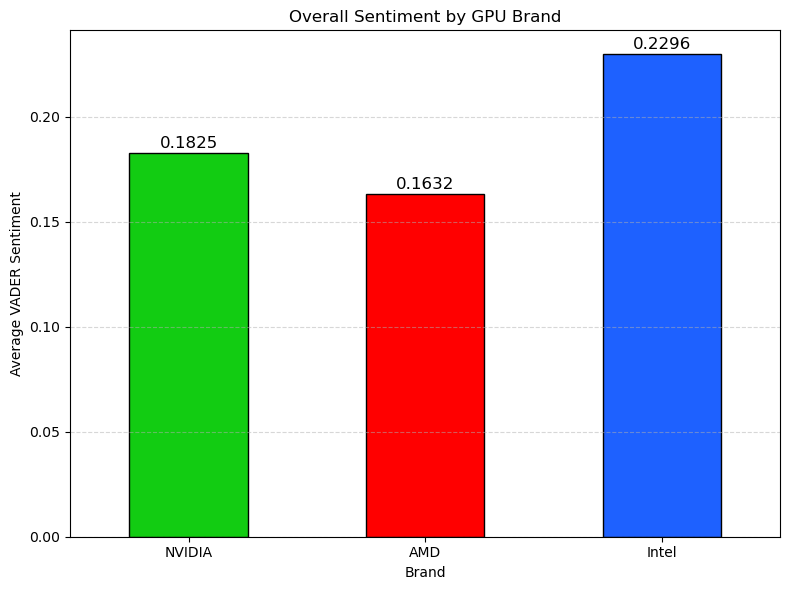

In [640]:
import matplotlib.pyplot as plt

nvidia_avg = nvidia_gpu_df["sentiment"].mean()
amd_avg = amd_gpu_df["sentiment"].mean()
intel_avg = intel_gpu_df["sentiment"].mean()

overall_sentiment_df = pd.DataFrame({
    "Brand": ["NVIDIA", "AMD", "Intel"],
    "Average Sentiment": [nvidia_avg, amd_avg, intel_avg]
})
brand_colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff0000",
    "Intel": "#1e61ff"
}
colors = [brand_colors[brand] for brand in overall_sentiment_df["Brand"]]

ax = overall_sentiment_df.plot(
    x="Brand",
    y="Average Sentiment",
    kind="bar",
    color=colors,
    edgecolor="black",
    figsize=(8, 6),
    legend=False
)

for bar in ax.containers[0]:
    height = bar.get_height()
    if pd.notna(height):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.001,
            f"{height:.4f}",
            ha='center',
            va='bottom',
            fontsize=12
        )

plt.title("Overall Sentiment by GPU Brand")
plt.ylabel("Average VADER Sentiment")
plt.xlabel("Brand")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

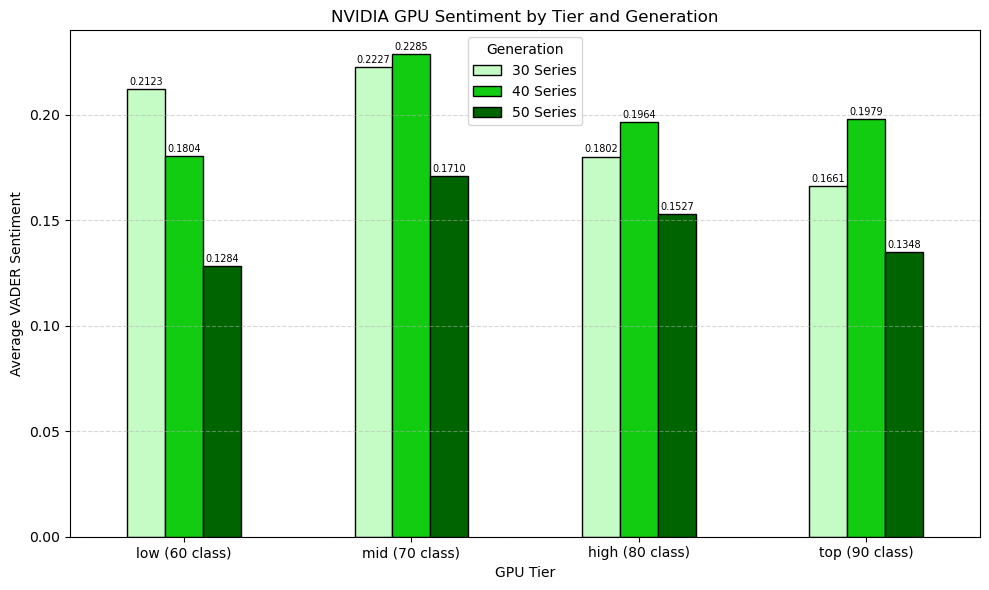

In [545]:
import matplotlib.pyplot as plt

# new labels
tier_order = ["low", "mid", "high", "top"]
class_labels = ["low (60 class)", "mid (70 class)", "high (80 class)", "top (90 class)"]

# function to get average sentiment by tier for specific generation
def get_avg_sentiment_by_tier(df, generation):
    filtered = df[(df["generation"] == generation)]
    return filtered.groupby("tier")["sentiment"].mean().reindex(tier_order)

# average sentiment for each generation
avg_30 = get_avg_sentiment_by_tier(nvidia_gpu_df, "30")
avg_40 = get_avg_sentiment_by_tier(nvidia_gpu_df, "40")
avg_50 = get_avg_sentiment_by_tier(nvidia_gpu_df, "50")

# combines data 
nvidiaGPUplot = pd.DataFrame({
    "30 Series": avg_30,
    "40 Series": avg_40,
    "50 Series": avg_50
})
nvidiaGPUplot.index = class_labels  # renaming gpu class/tier labels

colors = ["#c5fcc5", "#12cc12", "#006400"] 
ax = nvidiaGPUplot.plot(kind="bar", figsize=(10, 6), color=colors, edgecolor="black")
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if pd.notna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.001,
                f"{height:.4f}",
                ha='center',
                va='bottom',
                fontsize=7
            )
plt.title("NVIDIA GPU Sentiment by Tier and Generation")
plt.ylabel("Average VADER Sentiment")
plt.xlabel("GPU Tier")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Generation")
plt.tight_layout()
plt.show()

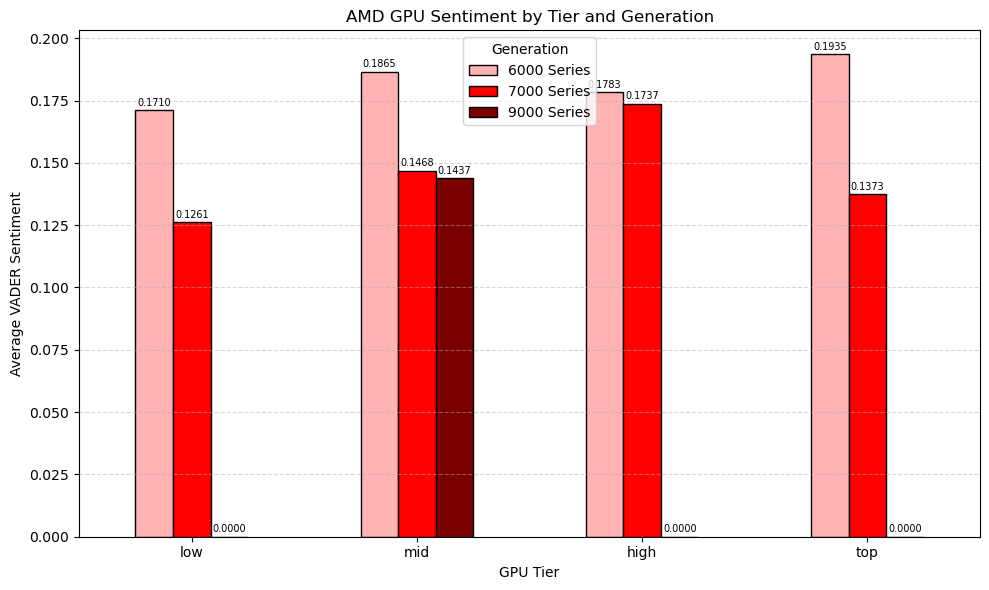

In [555]:
tier_order_amd = ["low", "mid", "high", "top"]

# function to get average sentiment by tier for specific generation
def get_avg_sentiment_by_tier(df, generation):
    filtered = df[(df["generation"] == generation)]
    return filtered.groupby("tier")["sentiment"].mean().reindex(tier_order_amd)

# average sentiment for each generation
avg_6000 = get_avg_sentiment_by_tier(amd_gpu_df, "6000")
avg_7000 = get_avg_sentiment_by_tier(amd_gpu_df, "7000")
avg_9000 = get_avg_sentiment_by_tier(amd_gpu_df, "9000")

# combines data 
amdGPUplot = pd.DataFrame({
    "6000 Series": avg_6000,
    "7000 Series": avg_7000,
    "9000 Series": avg_9000
})

colors = ["#ffb3b3", "#ff0000", "#7a0000"] 
ax = amdGPUplot.plot(kind="bar", figsize=(10, 6), color=colors, edgecolor="black")
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if pd.notna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.001,
                f"{height:.4f}",
                ha='center',
                va='bottom',
                fontsize=7
            )
plt.title("AMD GPU Sentiment by Tier and Generation")
plt.ylabel("Average VADER Sentiment")
plt.xlabel("GPU Tier")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Generation", loc="upper center")
plt.tight_layout()
plt.show()


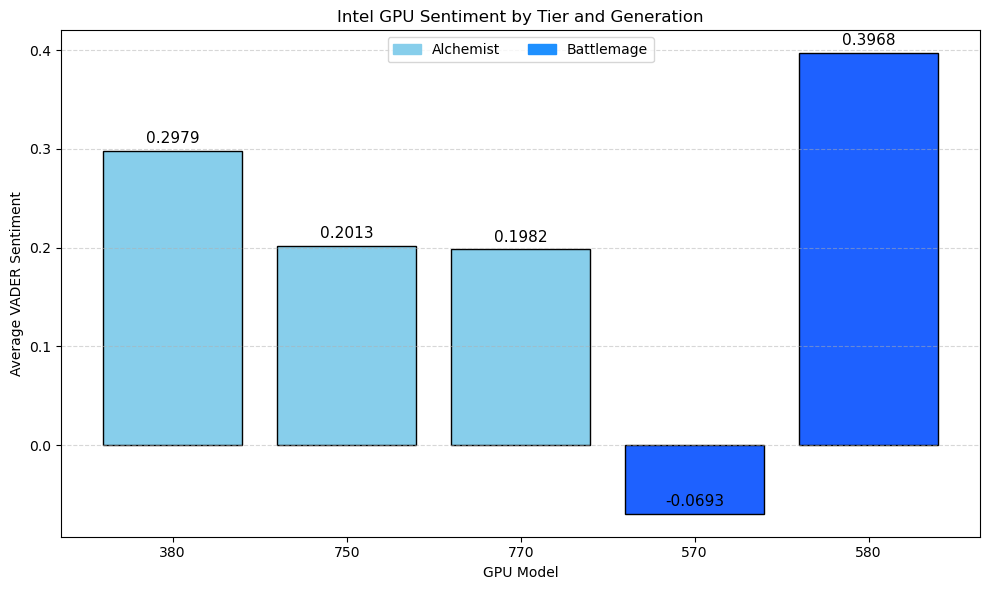

In [553]:
intel_tier_order = ["380", "750", "770", "570", "580"]

def get_avg_sentiment_by_intel_tier(df):
    filtered = df[(df["type"] == "post") & (df["tier"].isin(intel_tier_order))]
    return filtered.groupby("tier")["sentiment"].mean().reindex(intel_tier_order)

avg_intel_sentiment = get_avg_sentiment_by_intel_tier(intel_gpu_df)

colors = {
    "380": "#87ceeb",  # light blue for alchemist
    "750": "#87ceeb",
    "770": "#87ceeb",
    "570": "#1e61ff",  # darker blue for battlemage
    "580": "#1e61ff"
}

bar_colors = [colors[tier] for tier in avg_intel_sentiment.index]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(avg_intel_sentiment.index, avg_intel_sentiment.values, color=bar_colors, edgecolor="black")

for bar in bars:
    height = bar.get_height()
    if pd.notna(height):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.005,
            f"{height:.4f}",
            ha='center',
            va='bottom',
            fontsize=11
        )

legend_handles = [
    Patch(color="#87ceeb", label="Alchemist"),
    Patch(color="#1e90ff", label="Battlemage")
]
ax.set_title("Intel GPU Sentiment by Tier and Generation")
ax.set_ylabel("Average VADER Sentiment")
ax.set_xlabel("GPU Model")
ax.set_xticks(range(len(avg_intel_sentiment.index)))
ax.set_xticklabels(avg_intel_sentiment.index, rotation=0)
ax.grid(axis='y', linestyle='--', alpha=0.5)
ax.legend(handles=legend_handles, loc="upper center", ncol=2)
plt.tight_layout()
plt.show()

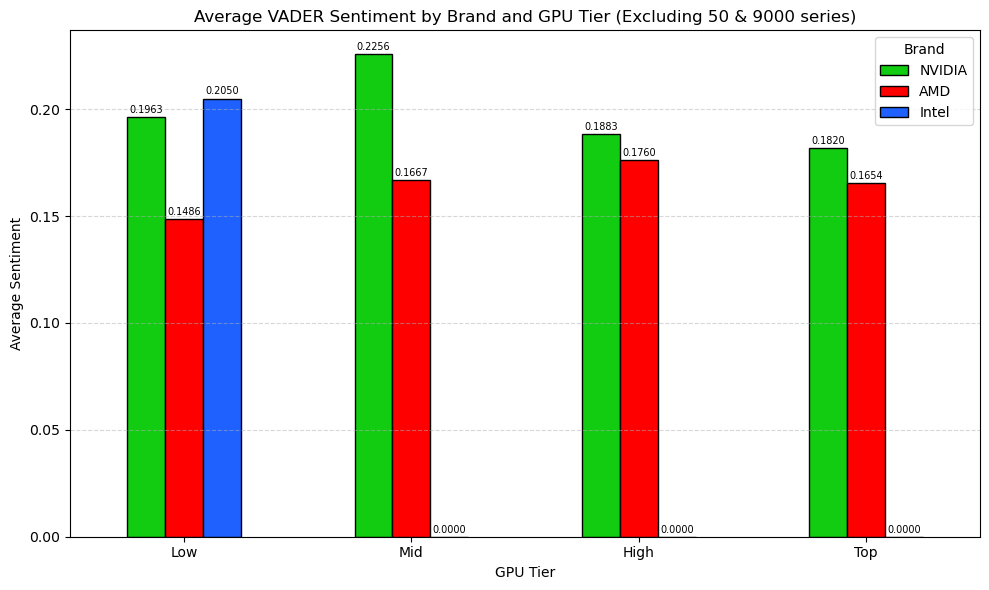

In [569]:
gpu_sentiment_scores = {
    "Low": {
        "NVIDIA": (0.2123 + 0.1804) / 2,   
        "AMD": (0.1710 + 0.1261) / 2,
        "Intel": (0.2979 + 0.2013 + 0.1982 + -0.0693 + 0.3968) / 5
    },
    "Mid": {
        "NVIDIA": (0.2227 + 0.2285) / 2,
        "AMD": (0.1865 + 0.1468) / 2
    },
    "High": {
        "NVIDIA": (0.1802 + 0.1964) / 2,
        "AMD": (0.1783 + 0.1737) / 2
    },
    "Top": {
        "NVIDIA": (0.1661 + 0.1979) / 2,
        "AMD": (0.1935 + 0.1373) / 2
    }
}

df = pd.DataFrame(gpu_sentiment_scores).T

colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff0000",
    "Intel": "#1e61ff"
}

ax = df.plot(kind="bar", figsize=(10, 6), color=[colors.get(col, "#cccccc") for col in df.columns], edgecolor="black")
plt.title("Average VADER Sentiment by Brand and GPU Tier (Excluding 50 & 9000 series)")
plt.ylabel("Average Sentiment")
plt.xlabel("GPU Tier")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Brand")
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if pd.notna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.001,
                f"{height:.4f}",
                ha='center',
                va='bottom',
                fontsize=7
            )
plt.tight_layout()
plt.show()

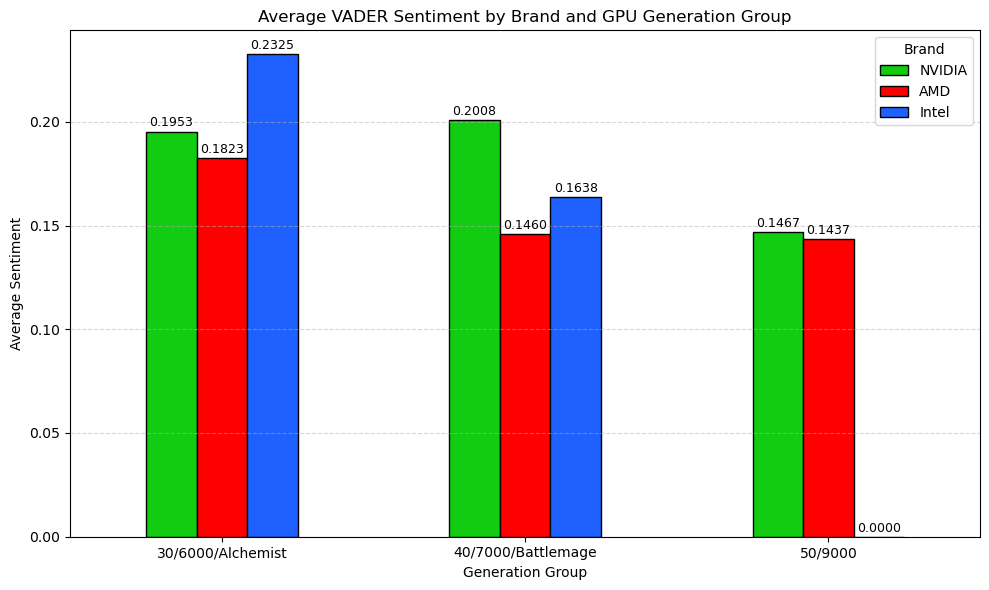

In [567]:
combined_generations = {
    "30/6000/Alchemist": {
        "NVIDIA": (0.2123 + 0.2227 + 0.1802 + 0.1661) / 4,
        "AMD": (0.1710 + 0.1865 + 0.1783 + 0.1935) / 4,
        "Intel": (0.2979 + 0.2013 + 0.1982) / 3
    },
    "40/7000/Battlemage": {
        "NVIDIA": (0.1804 + 0.2285 + 0.1964 + 0.1979) / 4,
        "AMD": (0.1261 + 0.1468 + 0.1737 +  0.1373) / 4,
        "Intel": (-0.0693 + 0.3968) / 2
    },
    "50/9000": {
        "NVIDIA": (0.1284 + 0.1710 + 0.1527 + 0.1348) / 4,
        "AMD": 0.1437  # amd only has mid tier so far
        # intel has no current gen 
    }
}

df_combined = pd.DataFrame(combined_generations).T

colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff0000",
    "Intel": "#1e61ff"
}

ax = df_combined.plot(kind="bar", figsize=(10, 6), color=[colors.get(col, "#cccccc") for col in df_combined.columns], edgecolor="black")
plt.title("Average VADER Sentiment by Brand and GPU Generation Group")
plt.ylabel("Average Sentiment")
plt.xlabel("Generation Group")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Brand")
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if pd.notna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.001,
                f"{height:.4f}",
                ha='center',
                va='bottom',
                fontsize=9
            )
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

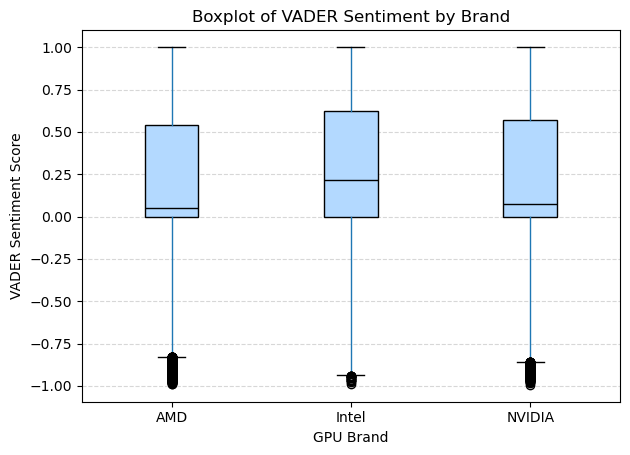

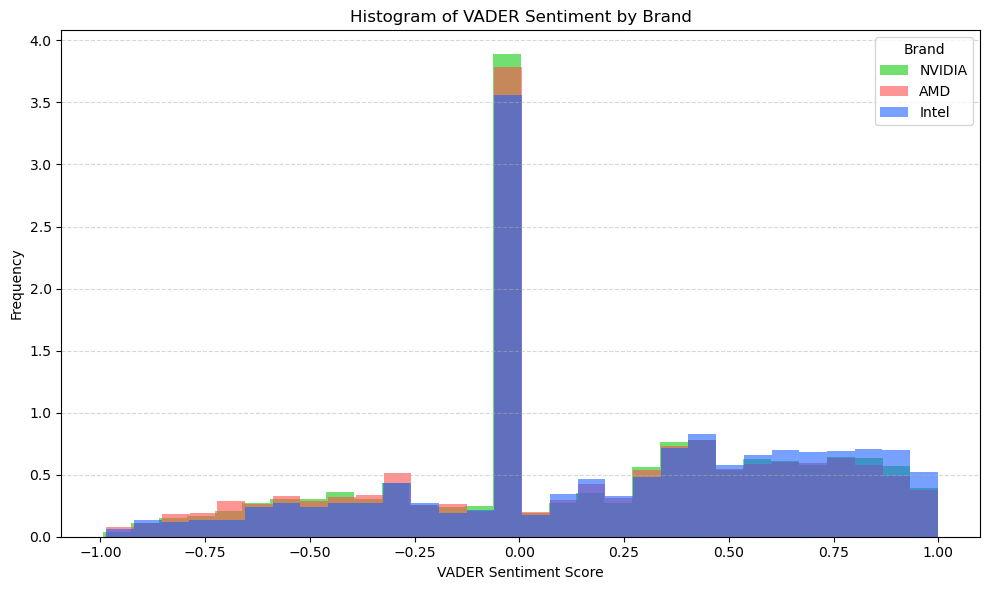

In [837]:

nvidia_df = pd.read_csv("nvidia_gpu_sentiment.csv")
amd_df = pd.read_csv("amd_gpu_sentiment.csv")
intel_df = pd.read_csv("intel_gpu_sentiment.csv")

nvidia_df["brand"] = "NVIDIA"
amd_df["brand"] = "AMD"
intel_df["brand"] = "Intel"

combined_df = pd.concat([nvidia_df, amd_df, intel_df], ignore_index=True)

plt.figure(figsize=(8, 6))
combined_df.boxplot(column="sentiment", by="brand", grid=False, patch_artist=True,
                    boxprops=dict(facecolor="#b3d9ff", color='black'),
                    medianprops=dict(color='black'))
plt.title("Boxplot of VADER Sentiment by Brand")
plt.suptitle("")  # Remove default subtitle
plt.ylabel("VADER Sentiment Score")
plt.xlabel("GPU Brand")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
brands = combined_df["brand"].unique()
colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff4d4d",
    "Intel": "#1e61ff"
}
for brand in brands:
    subset = combined_df[combined_df["brand"] == brand]
    plt.hist(subset["sentiment"], bins=30, alpha=0.6, label=brand,
             color=colors[brand], density=True)

plt.title("Histogram of VADER Sentiment by Brand")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Frequency")
plt.legend(title="Brand")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


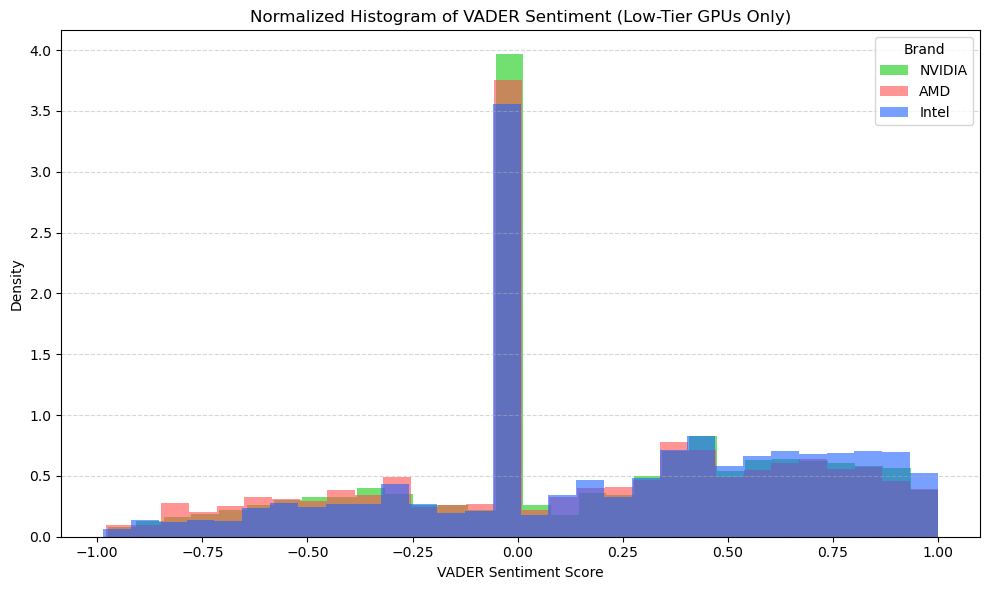

In [666]:
nvidia_df["brand"] = "NVIDIA"
amd_df["brand"] = "AMD"
intel_df["brand"] = "Intel"

# Assume all Intel GPUs are low tier
intel_df["tier"] = "low"

# Filter NVIDIA and AMD for low tier excluding 9000 series
nvidia_low = nvidia_df[(nvidia_df["tier"] == "low")]
amd_low = amd_df[(amd_df["tier"] == "low") & (amd_df["generation"] != "9000")]

# Filter Intel (only low tier)
intel_low = intel_df[intel_df["tier"] == "low"]

# Combine filtered data
low_tier_combined = pd.concat([nvidia_low, amd_low, intel_low], ignore_index=True)

# Plot normalized histogram
plt.figure(figsize=(10, 6))
colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff4d4d",
    "Intel": "#1e61ff"
}

for brand in ["NVIDIA", "AMD", "Intel"]:
    subset = low_tier_combined[low_tier_combined["brand"] == brand]
    plt.hist(subset["sentiment"], bins=30, alpha=0.6, label=brand,
             color=colors[brand], density=True)

plt.title("Normalized Histogram of VADER Sentiment (Low-Tier GPUs Only)")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Density")
plt.legend(title="Brand")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


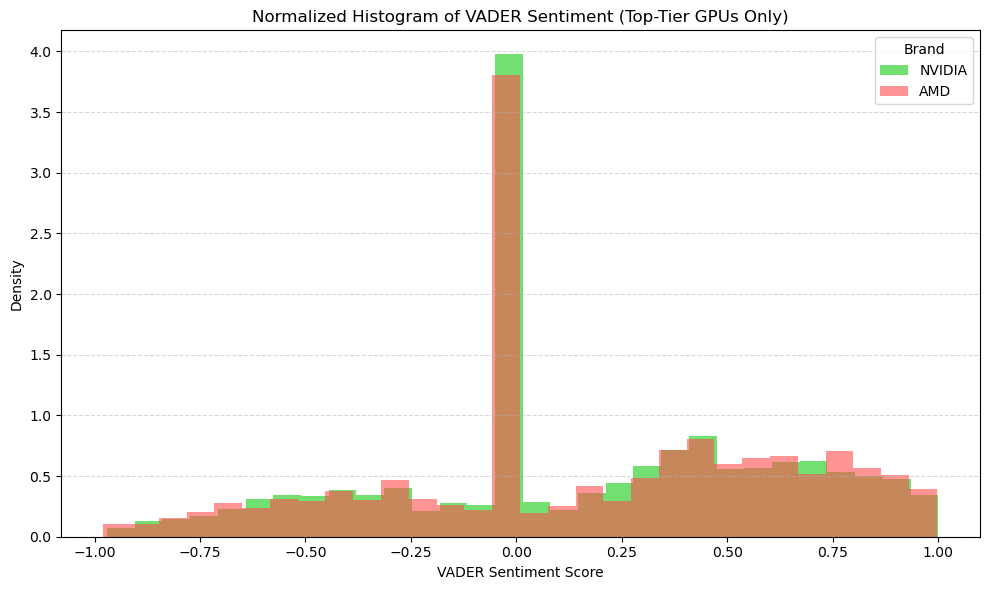

In [839]:

nvidia_df["brand"] = "NVIDIA"
amd_df["brand"] = "AMD"

nvidia_top = nvidia_df[nvidia_df["tier"] == "top"]
amd_top = amd_df[(amd_df["tier"] == "top")]

top_tier_combined = pd.concat([nvidia_top, amd_top], ignore_index=True)
plt.figure(figsize=(10, 6))
colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff4d4d"
}

for brand in ["NVIDIA", "AMD"]:
    subset = top_tier_combined[top_tier_combined["brand"] == brand]
    plt.hist(subset["sentiment"], bins=30, alpha=0.6, label=brand,
             color=colors[brand], density=True)

plt.title("Normalized Histogram of VADER Sentiment (Top-Tier GPUs Only)")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Density")
plt.legend(title="Brand")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

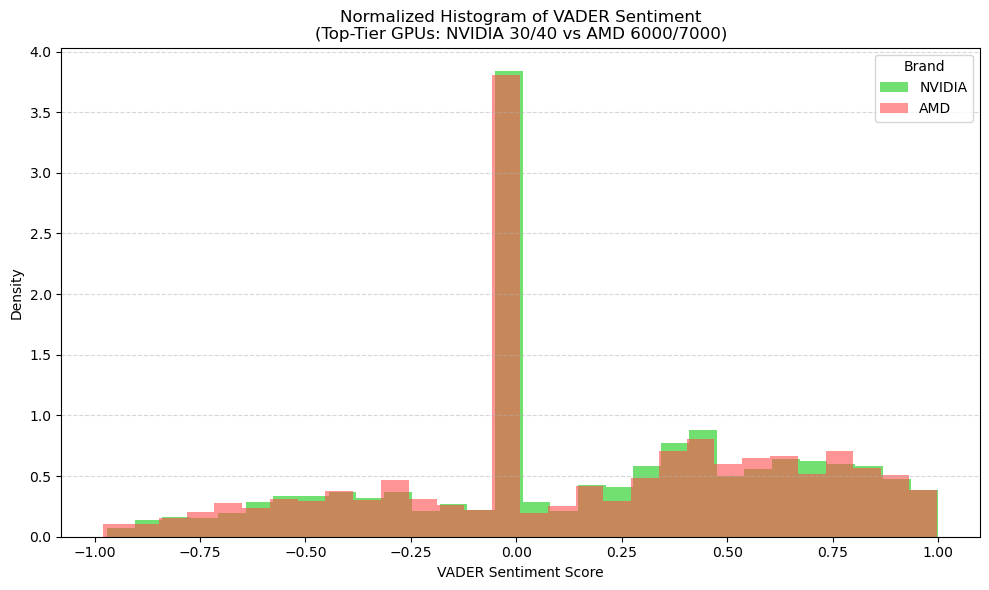

In [841]:
nvidia_df["brand"] = "NVIDIA"
amd_df["brand"] = "AMD"

nvidia_top = nvidia_df[
    (nvidia_df["tier"] == "top") &
    (nvidia_df["generation"].astype(str).isin(["30", "40"]))
]

amd_top = amd_df[
    (amd_df["tier"] == "top") &
    (amd_df["generation"].astype(str).isin(["6000", "7000"]))
]

top_tier_combined = pd.concat([nvidia_top, amd_top], ignore_index=True)

plt.figure(figsize=(10, 6))
colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff4d4d"
}

for brand in ["NVIDIA", "AMD"]:
    subset = top_tier_combined[top_tier_combined["brand"] == brand]
    plt.hist(subset["sentiment"], bins=30, alpha=0.6, label=brand,
             color=colors[brand], density=True)

plt.title("Normalized Histogram of VADER Sentiment\n(Top-Tier GPUs: NVIDIA 30/40 vs AMD 6000/7000)")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Density")
plt.legend(title="Brand")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


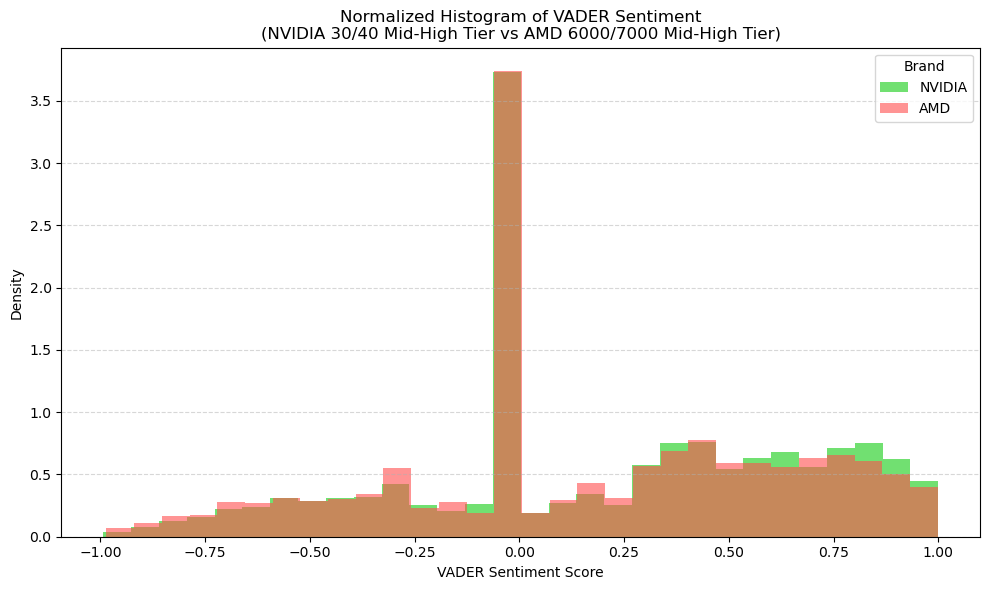

In [843]:
nvidia_df = pd.read_csv("nvidia_gpu_sentiment.csv")
amd_df = pd.read_csv("amd_gpu_sentiment.csv")

nvidia_df["brand"] = "NVIDIA"
amd_df["brand"] = "AMD"

nvidia_filtered = nvidia_df[
    (nvidia_df["tier"].isin(["mid", "high"])) &
    (nvidia_df["generation"].astype(str).isin(["30", "40"]))
]
amd_filtered = amd_df[
    (amd_df["tier"].isin(["mid", "high"])) &
    (amd_df["generation"].astype(str).isin(["6000", "7000"]))
]

combined = pd.concat([nvidia_filtered, amd_filtered], ignore_index=True)

plt.figure(figsize=(10, 6))
colors = {
    "NVIDIA": "#12cc12",
    "AMD": "#ff4d4d"
}

handles = []
labels = []

for brand in ["NVIDIA", "AMD"]:
    subset = combined[combined["brand"] == brand]
    if not subset.empty:
        hist = plt.hist(subset["sentiment"], bins=30, alpha=0.6,
                        label=brand, color=colors[brand], density=True)
        handles.append(hist[2][0])  # Get patch for legend
        labels.append(brand)

plt.title("Normalized Histogram of VADER Sentiment\n(NVIDIA 30/40 Mid-High Tier vs AMD 6000/7000 Mid-High Tier)")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Density")
plt.legend(handles, labels, title="Brand")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


## Sentiment for upscaling technology

In [571]:
def clean_text(text):
    return re.sub(r"http\S+|www\S+|https\S+", "", text)

with open("upscale_tech_comparison.json", "r", encoding="utf-8") as f:
    all_data = json.load(f)

sentiment_results = []

for post in all_data:
    if post.get("category") == "comparison":
        continue

    category = post.get("category", "")
    title = post.get("title", "")
    selftext = post.get("selftext", "")
    comments = post.get("comments", [])

    brand = {
        "dlss_only": "NVIDIA",
        "fsr_only": "AMD",
        "xess_only": "Intel"
    }.get(category, "Unknown")

    post_text = clean_text(f"{title} {selftext}")
    post_score = vader.polarity_scores(post_text)["compound"]

    sentiment_results.append({
        "brand": brand,
        "category": category,
        "type": "post",
        "sentiment": post_score
    })

    for comment in comments:
        comment_clean = clean_text(comment)
        if not comment_clean.strip():
            continue
        comment_score = vader.polarity_scores(comment_clean)["compound"]
        sentiment_results.append({
            "brand": brand,
            "category": category,
            "type": "comment",
            "sentiment": comment_score
        })

upscaling_sentiment_df = pd.DataFrame(sentiment_results)
upscaling_sentiment_df.to_csv("upscaling_sentiment_results.csv", index=False)

In [575]:
upscaling_sentiment_df.head(-1)

,brand,category,type,sentiment
0,NVIDIA,dlss_only,post,0.0000
1,NVIDIA,dlss_only,comment,0.1027
2,NVIDIA,dlss_only,comment,0.2023
3,NVIDIA,dlss_only,comment,0.0000
4,NVIDIA,dlss_only,comment,0.5818
...,...,...,...,...
16571,Intel,xess_only,comment,0.0000
16572,Intel,xess_only,comment,0.7574
16573,Intel,xess_only,comment,0.7783
16574,Intel,xess_only,comment,-0.0516


## Visualizations for GPU sentiment analysis

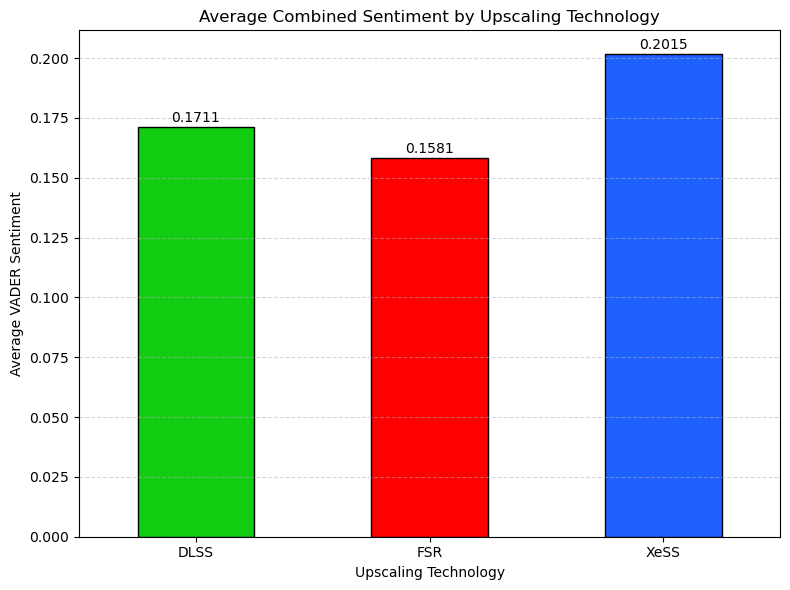

In [845]:
import matplotlib.pyplot as plt

upscale_name = {
    "dlss_only": "DLSS",
    "fsr_only": "FSR",
    "xess_only": "XeSS"
}
brand_colors = {
    "DLSS": "#12cc12", 
    "FSR": "#ff0000",   
    "XeSS": "#1e61ff"  
}

df_plot = upscaling_sentiment_df.copy()
df_plot["Upscaling Tech"] = df_plot["category"].map(upscale_name)

combined_sentiment = (
    df_plot.groupby("Upscaling Tech")["sentiment"]
    .mean()
    .reindex(["DLSS", "FSR", "XeSS"])
)

colors = [brand_colors[tech] for tech in combined_sentiment.index]
ax = combined_sentiment.plot(
    kind="bar",
    figsize=(8, 6),
    color=colors,
    edgecolor="black"
)

for bar in ax.containers[0]:
    height = bar.get_height()
    if pd.notna(height):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + 0.001,
            f"{height:.4f}",
            ha='center',
            va='bottom',
            fontsize=10
        )

plt.title("Average Combined Sentiment by Upscaling Technology")
plt.ylabel("Average VADER Sentiment")
plt.xlabel("Upscaling Technology")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


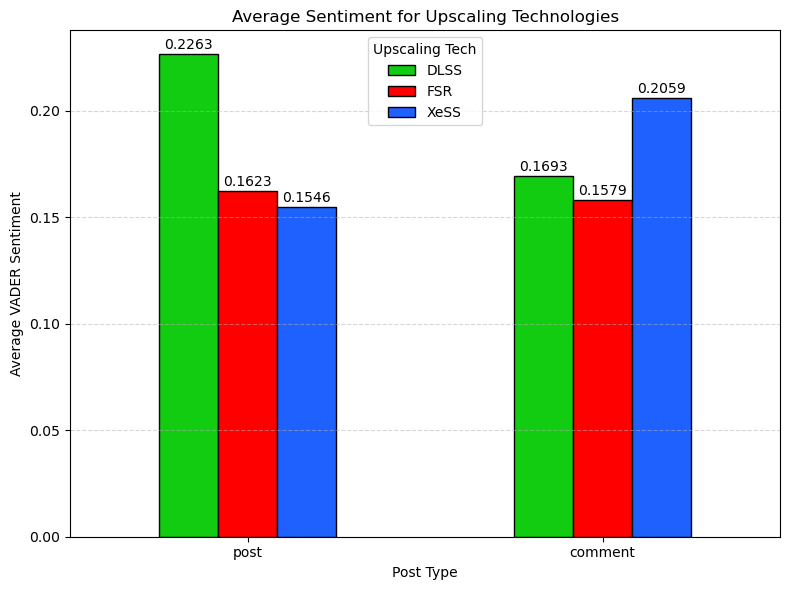

In [600]:
upscale_name = {
    "dlss_only": "DLSS",
    "fsr_only": "FSR",
    "xess_only": "XeSS"
}
df_plot = upscaling_sentiment_df.copy()
df_plot["Upscaling Tech"] = df_plot["category"].map(upscale_name)

avg_sentiment = df_plot.groupby(["Upscaling Tech", "type"])["sentiment"].mean().unstack()
avg_sentiment = avg_sentiment[["post", "comment"]]  
avg_sentiment = avg_sentiment.T  

# defining brand colors
colors = {
    "DLSS": "#12cc12",   
    "FSR": "#ff0000",    
    "XeSS": "#1e61ff"    
}
plot_colors = [colors[tech] for tech in avg_sentiment.columns]
ax = avg_sentiment.plot(kind="bar", figsize=(8, 6), color=plot_colors, edgecolor="black")
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if pd.notna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.001,
                f"{height:.4f}",
                ha='center',
                va='bottom',
                fontsize=10
            )
plt.title("Average Sentiment for Upscaling Technologies")
plt.ylabel("Average VADER Sentiment")
plt.xlabel("Post Type")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Upscaling Tech", loc = "upper center")
plt.tight_layout()
plt.show()

<Figure size 800x600 with 0 Axes>

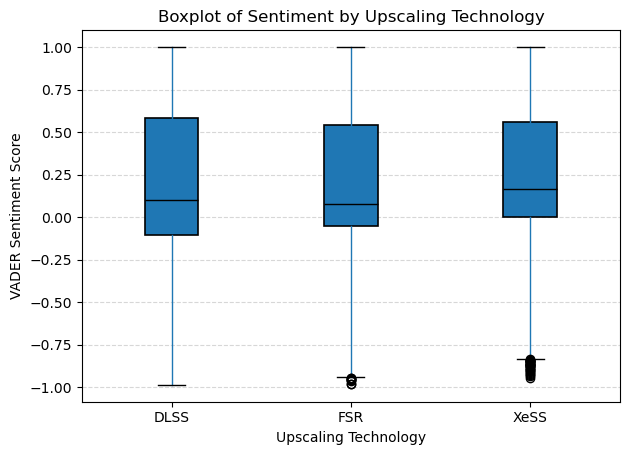

In [847]:
brand_colors = {
    "DLSS": "#12cc12",  
    "FSR": "#ff0000",   
    "XeSS": "#1e61ff"   
}

df_plot = upscaling_sentiment_df.copy()
upscale_name = {"dlss_only": "DLSS", "fsr_only": "FSR", "xess_only": "XeSS"}
df_plot["Upscaling Tech"] = df_plot["category"].map(upscale_name)

plt.figure(figsize=(8, 6))
box = df_plot.boxplot(column="sentiment", by="Upscaling Tech", patch_artist=True,
                      grid=False, showfliers=True,
                      boxprops=dict(linewidth=1.2),
                      medianprops=dict(color='black'))

for patch, tech in zip(box.artists, ["DLSS", "FSR", "XeSS"]):
    patch.set_facecolor(brand_colors[tech])
    patch.set_edgecolor("black")

plt.title("Boxplot of Sentiment by Upscaling Technology")
plt.suptitle("")  # Remove automatic title
plt.xlabel("Upscaling Technology")
plt.ylabel("VADER Sentiment Score")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


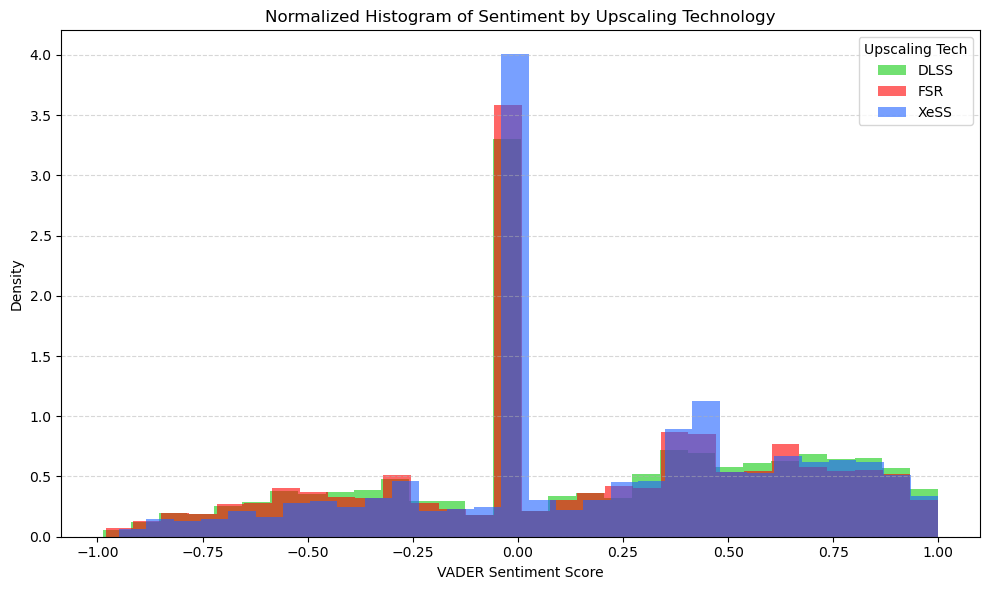

In [849]:
plt.figure(figsize=(10, 6))

for tech in ["DLSS", "FSR", "XeSS"]:
    subset = df_plot[df_plot["Upscaling Tech"] == tech]
    plt.hist(subset["sentiment"], bins=30, alpha=0.6, label=tech,
             color=brand_colors[tech], density=True)

plt.title("Normalized Histogram of Sentiment by Upscaling Technology")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Density")
plt.legend(title="Upscaling Tech")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


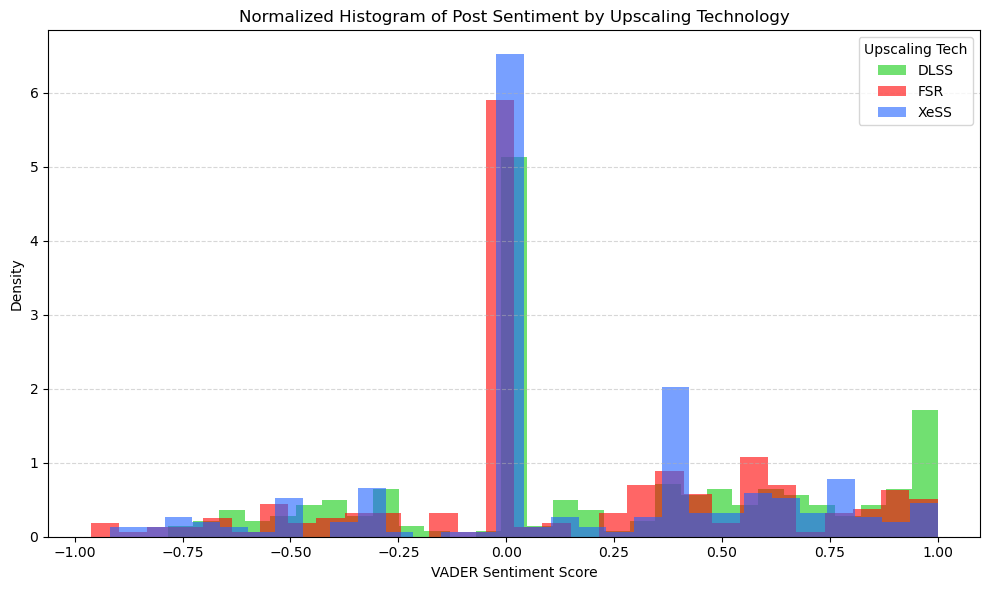

In [851]:
plt.figure(figsize=(10, 6))

for tech in ["DLSS", "FSR", "XeSS"]:
    subset = df_plot[
        (df_plot["Upscaling Tech"] == tech) & (df_plot["type"] == "post")
    ]
    plt.hist(subset["sentiment"], bins=30, alpha=0.6, label=tech,
             color=brand_colors[tech], density=True)

plt.title("Normalized Histogram of Post Sentiment by Upscaling Technology")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Density")
plt.legend(title="Upscaling Tech")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


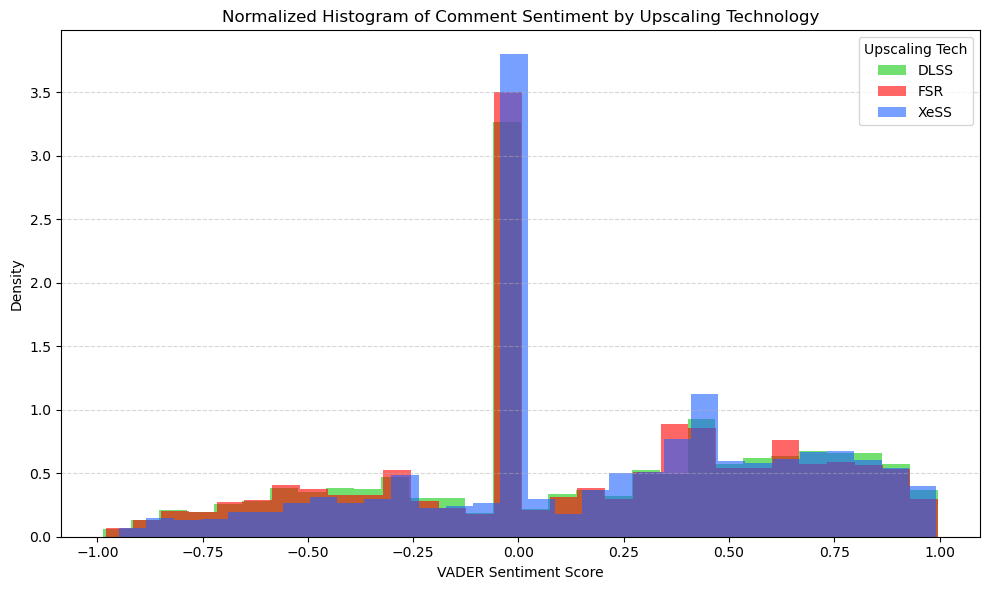

In [853]:
plt.figure(figsize=(10, 6))

for tech in ["DLSS", "FSR", "XeSS"]:
    subset = df_plot[
        (df_plot["Upscaling Tech"] == tech) & (df_plot["type"] == "comment")
    ]
    plt.hist(subset["sentiment"], bins=30, alpha=0.6, label=tech,
             color=brand_colors[tech], density=True)

plt.title("Normalized Histogram of Comment Sentiment by Upscaling Technology")
plt.xlabel("VADER Sentiment Score")
plt.ylabel("Density")
plt.legend(title="Upscaling Tech")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

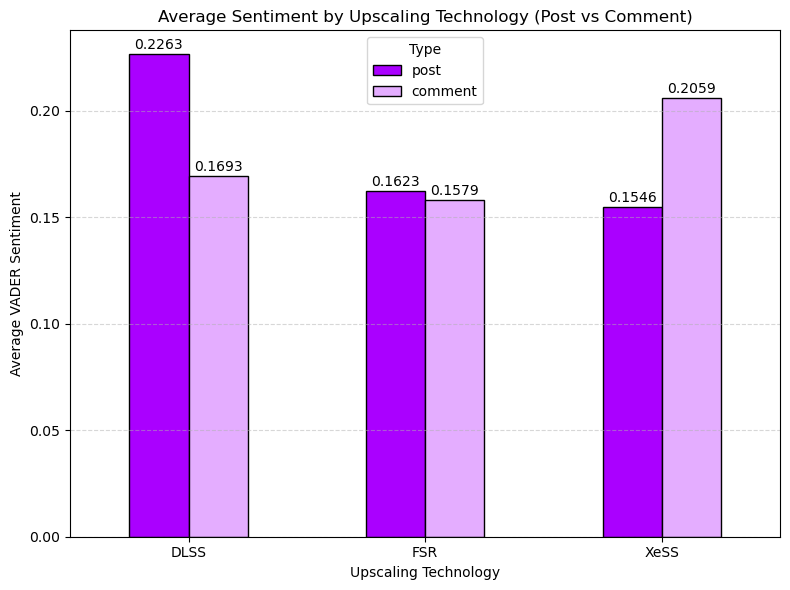

In [592]:
upscale_name = {
    "dlss_only": "DLSS",
    "fsr_only": "FSR",
    "xess_only": "XeSS"
}

df_plot = upscaling_sentiment_df.copy()
df_plot["Upscaling Tech"] = df_plot["category"].map(upscale_name)
avg_sentiment = df_plot.groupby(["Upscaling Tech", "type"])["sentiment"].mean().unstack()
avg_sentiment = avg_sentiment[["post", "comment"]]

colors = ["#aa00ff", "#e4adff"] 
ax = avg_sentiment.plot(kind="bar", figsize=(8, 6), color=colors, edgecolor="black")

for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        if pd.notna(height):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                height + 0.001,
                f"{height:.4f}",
                ha='center',
                va='bottom',
                fontsize=10
            )
plt.title("Average Sentiment by Upscaling Technology (Post vs Comment)")
plt.ylabel("Average VADER Sentiment")
plt.xlabel("Upscaling Technology")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.legend(title="Type")
plt.tight_layout()
plt.show()

# Topic Modelling

In [746]:
import math
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np

In [ ]:
nvidiaTKDF, nvidiaTokens, nvidiaFreq, nvidiaRawCount = textTokenizer("nvidiaGPU.json")
amdTKDF, amdTokens, amdFreq, amdRawCount = textTokenizer("amdGPU.json")
intelTKDF, intelTokens, intelFreq, intelRawCount = textTokenizer("intelGPU.json")

In [700]:
nvidiaTKDF

,index,tokens
0,0,"[resize, bar, tested, rtx, 3060, extra, perfor..."
1,1,"[nvidia, 3050ti, i712700h, nvdia, rtx, 3060, u..."
2,2,"[nvidia, geforce, rtx, 3060, launch, analysis,..."
3,3,"[550w, psu, enough, rtx, 3060, 5600, 65w, cpu,..."
4,4,"[rx7600, better, rtx, 3060, 12gb, option, perf..."
...,...,...
1139,1139,"[geforce, rtx, 5090, review, megathread, whelm..."
1140,1140,"[upgrade, 5090, gifgiphyijjlghtwvtmmtgkqw, wel..."
1141,1141,"[nvidia, geforce, rtx, 5090, feature, 1667, po..."
1142,1142,"[got, 5090, priority, email, current, 5090, nv..."


In [776]:
topicNum = 4
wordNumToDisplay = 15
featureNum = 5000
LDAtokens = [" ".join(tokens) for tokens in nvidiaTKDF["tokens"]]
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(LDAtokens)
tfFeatureNames = tfVectorizer.get_feature_names_out()
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [777]:
def display_topics(model, featureNames, numTopWords):
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [778]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
game card like gpu fan look case dont power good really performance cpu rtx fps
Topic 1:
card price nvidia like performance rtx 4080 4070 super series people 5080 vram 4090 dont
Topic 2:
4060 8gb vram 5060 3060 1080p 16gb game rtx card 5060ti better 3060ti 1440p 4060ti
Topic 3:
card like nvidia buy people dont got stock time asus evga issue warranty 5090 best


In [782]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

In [784]:
def displayWordcloud(model, featureNames):
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    topicNum = len(model.components_)
    plotColNum = 3
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

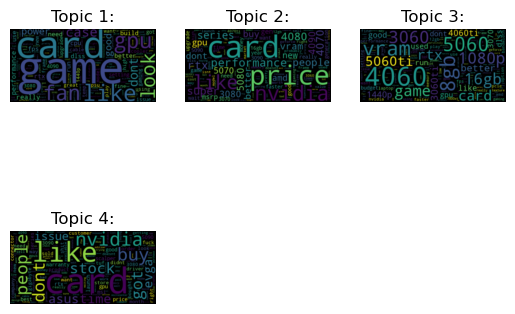

In [786]:
displayWordcloud(ldaModel, tfFeatureNames)

In [800]:
topicNum = 4
wordNumToDisplay = 15
featureNum = 5000
LDAtokens = [" ".join(tokens) for tokens in amdTKDF["tokens"]]
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(LDAtokens)
tfFeatureNames = tfVectorizer.get_feature_names_out()
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [802]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
gre memory edition clock china performance 6400 golden prompt rabbit kit mhz higher rdna amd
Topic 1:
card amd like model dont people got stock gpu msrp reference time price issue launch
Topic 2:
gpu fan like cpu power card case look build good cooler psu dont really got
Topic 3:
amd price card performance like nvidia better game people dont gpu good really vram buy


In [804]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

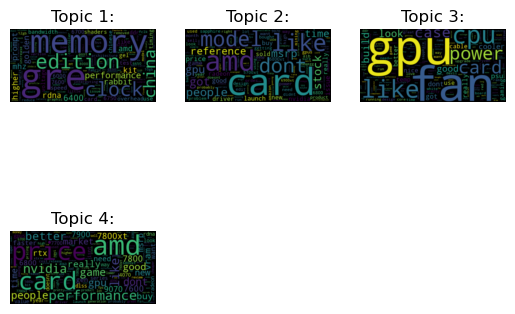

In [806]:
displayWordcloud(ldaModel, tfFeatureNames)

In [816]:
topicNum = 3
wordNumToDisplay = 15
featureNum = 5000
LDAtokens = [" ".join(tokens) for tokens in intelTKDF["tokens"]]
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words='english')
tf = tfVectorizer.fit_transform(LDAtokens)
tfFeatureNames = tfVectorizer.get_feature_names_out()
ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

In [818]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
a380 performance price 1650 intel arc gtx better really year card market benchmark super gen
Topic 1:
intel card arc driver gpu like a770 amd performance dont nvidia price better game a750
Topic 2:
b580 game like gpu cpu performance b570 vram driver used intel work price issue better


In [820]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

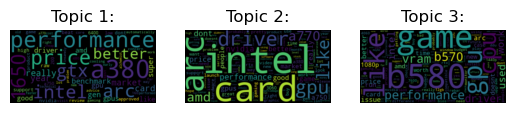

In [822]:
displayWordcloud(ldaModel, tfFeatureNames)